# GANgster
In this notebook we will try to generate mugshots with our generator

In [1]:
import os
import glob
import json

import torch
from torch import nn
from IPython import display

import PIL
import time

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# os.system("cd /content/data && unzip /content/drive/MyDrive/data.zip")

In [4]:
image_size = 96
generator_entry = 50

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("running on GPU")
else:
    device = torch.device("cpu")
    print("running on CPU")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Resize((image_size, image_size)), transforms.Grayscale()]
)

running on GPU


In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, transform=None):
        self.df = []
        for index, filepath in enumerate(glob.glob(f"{images_folder}/*")):
            if index % 10 == 0:
                filename = os.path.split(filepath)[1]
                image = PIL.Image.open(f"{images_folder}/{filename}")
                if transform is not None:
                    image = transform(image)
                self.df.append((image, filename))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return self.df[index]


train_set = CustomDataset(
    images_folder="../data/front/front", transform=transform
)

In [10]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

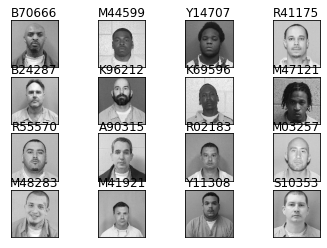

In [11]:
real_samples, real_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(real_samples[i].reshape(image_size, image_size), cmap="gray")
    ax.set_title(real_labels[i], fontsize=12, pad=1.0)
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size ** 2, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), image_size ** 2)
        output = self.model(x)
        return output

In [13]:
discriminator = Discriminator().to(device=device)
discriminator.load_state_dict(torch.load("../models/2000_96_1e-05/discriminator"))

<All keys matched successfully>

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(generator_entry, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, image_size ** 2),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, image_size, image_size)
        return output

In [15]:
generator = Generator().to(device=device)
generator.load_state_dict(torch.load("../models/2000_96_1e-05/generator"))

<All keys matched successfully>

In [16]:
lr = 0.00001
num_epochs = 2000
show_every = 10
loss_function = nn.BCELoss()

print("DATASET SIZE :", len(train_set))

DATASET SIZE : 7001


In [17]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [18]:
per_x_time = []
losses = {
    "generator": [],
    "discriminator": []
}

show_test_sample = torch.randn(1, generator_entry).to(device=device)

In [19]:
evolution = []

In [20]:
epoch_start = time.time()
for epoch in range(num_epochs):
    loss_discriminator = 0
    loss_generator = 0
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        
        real_samples = real_samples.to(device=device)
        real_samples_size = real_samples.shape[0]

        # Set the labels of the real data to one (Using the size of the real samples array)
        real_samples_labels = torch.ones((real_samples_size, 1)).to(device=device)

        # Set the labels of the fake data to zero
        latent_space_samples = torch.randn((real_samples_size, generator_entry)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((real_samples_size, 1)).to(device=device)

        # Concatenate true and fake data
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data to train the generator
        latent_space_samples = torch.randn((real_samples_size, generator_entry)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

    # Show loss
    if epoch % show_every == 0 and epoch != 0:
        per_x_time.append(time.time() - epoch_start)
        epoch_start = time.time()
        losses["generator"].append(float(loss_generator))
        losses["discriminator"].append(float(loss_discriminator))

        ld = str(round(float(loss_discriminator), 10)).zfill(12)
        lg = str(round(float(loss_generator), 10)).zfill(12)
        it = str(round(per_x_time[-1], 4)).zfill(9)
        av = str(round(sum(per_x_time)/len(per_x_time), 2)).zfill(6)
        seconds = round(
            ((sum(per_x_time)/len(per_x_time)) * ((num_epochs - epoch)/show_every)),
            2
        )
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        tl = "%d:%02d:%02d" % (h, m, s)
        print(f"[+] EPOCH : {str(epoch).zfill(7)} | LD.: {ld} | LG.: {lg} | IT : {it}s | AV : {av} | TL : {tl}""")
        
        generated_sample = generator(show_test_sample)
        generated_sample = generated_sample.cpu().detach()
        image = transforms.ToPILImage()(generated_sample[0].reshape(image_size, image_size))
        evolution.append(image)

[+] EPOCH : 0000010 | LD.: 000.11509718 | LG.: 2.2595305443 | IT : 0056.7955s | AV : 0056.8 | TL : 3:08:22
[+] EPOCH : 0000020 | LD.: 0.0317099616 | LG.: 3.6172113419 | IT : 0052.1829s | AV : 054.49 | TL : 2:59:48
[+] EPOCH : 0000030 | LD.: 0.0990964696 | LG.: 4.8762664795 | IT : 0052.5271s | AV : 053.84 | TL : 2:56:45
[+] EPOCH : 0000040 | LD.: 0.0462592877 | LG.: 3.3191480637 | IT : 0052.4343s | AV : 053.48 | TL : 2:54:43
[+] EPOCH : 0000050 | LD.: 0.1961942315 | LG.: 3.6169383526 | IT : 0052.4653s | AV : 053.28 | TL : 2:53:09
[+] EPOCH : 0000060 | LD.: 0.0690246299 | LG.: 4.3235988617 | IT : 00052.528s | AV : 053.16 | TL : 2:51:52
[+] EPOCH : 0000070 | LD.: 0.0962172002 | LG.: 04.100672245 | IT : 0052.5224s | AV : 053.07 | TL : 2:50:41
[+] EPOCH : 0000080 | LD.: 0.2480909675 | LG.: 2.6741998196 | IT : 0052.5193s | AV : 0053.0 | TL : 2:49:35
[+] EPOCH : 0000090 | LD.: 00.137717858 | LG.: 2.4355959892 | IT : 0052.6765s | AV : 052.96 | TL : 2:48:35
[+] EPOCH : 0000100 | LD.: 0.06799542

In [21]:
path = f"/content/{num_epochs}_{image_size}_{lr}"

x = 1
while os.path.isdir(path):
    path = f"/content/{num_epochs}_{image_size}_{lr}_{x}"
    x += 1

os.mkdir(path)

torch.save(generator.state_dict(), f"{path}/generator")
torch.save(discriminator.state_dict(), f"{path}/discriminator")

In [22]:
evolution[0].save(f'{path}/progressive_text.gif', format='GIF',
               append_images=evolution[1:], save_all=True, duration=75, loop=1)

In [24]:
data = {
    "avg_time": round(sum(per_x_time)/len(per_x_time), 2),
    "total_time": sum(per_x_time),
    "losses": losses
}

with open(f"{path}/meta.json", 'w+') as f:
    json.dump(data, f, indent=4)

In [17]:
samples_amount = 150

Average score : 8.2 %


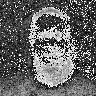

0.0 %


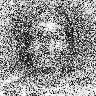

0.06 %


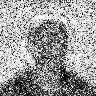

5.27 %


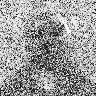

0.1 %


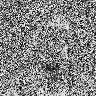

0.73 %


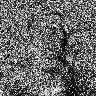

0.49 %


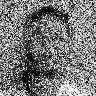

7.38 %


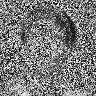

0.08 %


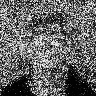

0.36 %


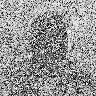

2.42 %


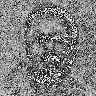

1.72 %


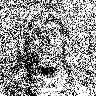

2.66 %


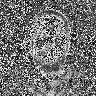

0.92 %


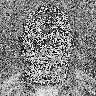

12.91 %


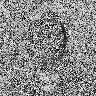

41.44 %


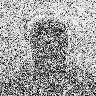

2.29 %


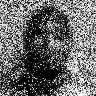

8.95 %


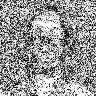

3.51 %


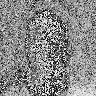

53.02 %


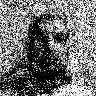

3.66 %


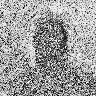

4.3 %


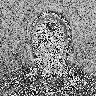

8.84 %


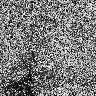

0.82 %


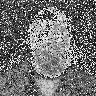

3.24 %


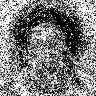

16.93 %


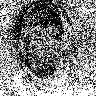

1.42 %


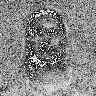

1.0 %


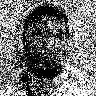

13.57 %


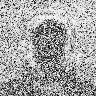

7.47 %


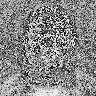

52.22 %


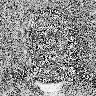

1.12 %


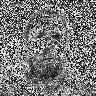

1.49 %


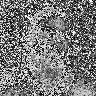

0.49 %


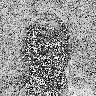

10.12 %


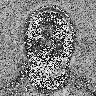

4.01 %


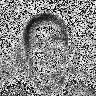

21.29 %


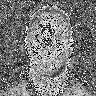

1.4 %


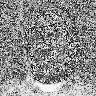

2.34 %


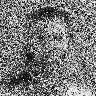

8.22 %


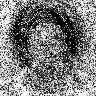

4.7 %


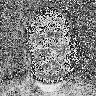

92.13 %


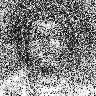

11.73 %


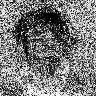

48.06 %


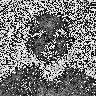

1.09 %


2.77 %


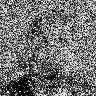

0.05 %


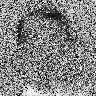

0.37 %


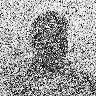

0.13 %


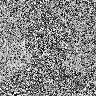

7.0 %


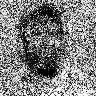

0.08 %


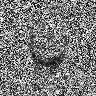

4.45 %


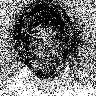

2.17 %


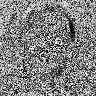

29.86 %


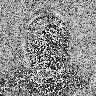

8.93 %


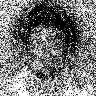

1.52 %


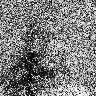

5.21 %


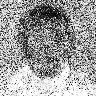

0.31 %


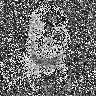

1.11 %


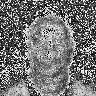

11.92 %


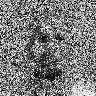

0.83 %


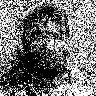

10.11 %


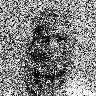

37.77 %


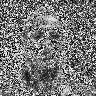

0.29 %


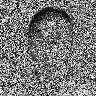

27.92 %


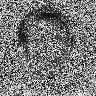

0.04 %


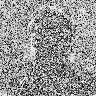

0.9 %


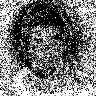

4.06 %


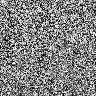

5.41 %


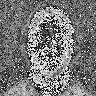

10.52 %


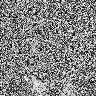

0.12 %


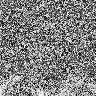

2.75 %


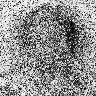

0.04 %


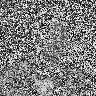

9.34 %


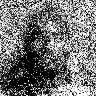

0.36 %


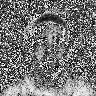

0.06 %


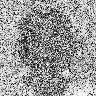

0.05 %


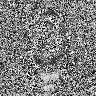

0.72 %


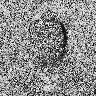

1.14 %


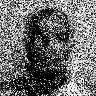

3.17 %


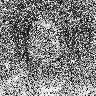

0.05 %


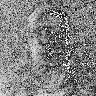

2.16 %


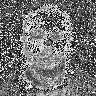

3.95 %


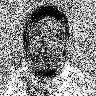

3.65 %


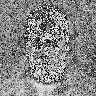

0.31 %


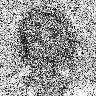

0.4 %


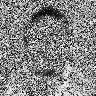

0.03 %


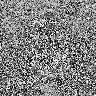

11.09 %


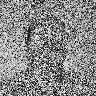

0.69 %


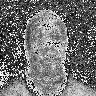

19.62 %


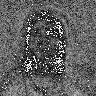

0.01 %


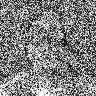

0.12 %


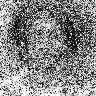

1.07 %


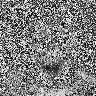

0.03 %


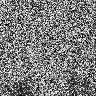

0.92 %


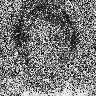

14.6 %


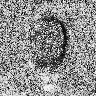

0.35 %


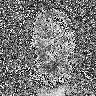

45.44 %


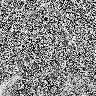

21.25 %


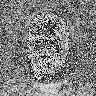

0.21 %


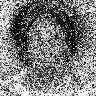

0.32 %


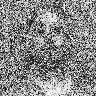

0.1 %


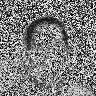

61.43 %


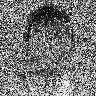

2.57 %


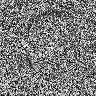

0.24 %


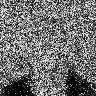

2.35 %


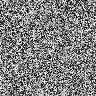

0.38 %


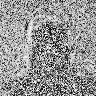

2.71 %


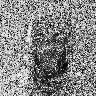

1.63 %


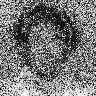

2.7 %


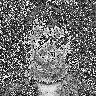

1.05 %


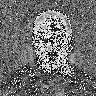

6.74 %


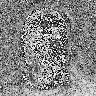

40.07 %


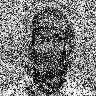

0.04 %


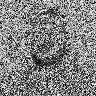

8.23 %


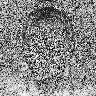

0.76 %


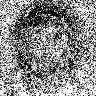

2.5 %


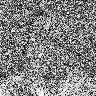

0.34 %


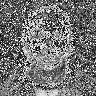

0.18 %


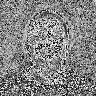

0.26 %


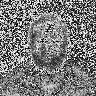

32.06 %


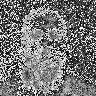

4.18 %


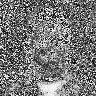

82.82 %


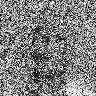

11.01 %


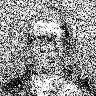

0.56 %


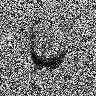

6.58 %


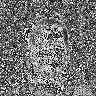

0.29 %


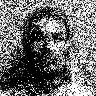

3.02 %


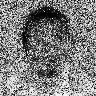

0.1 %


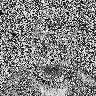

0.06 %


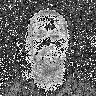

3.03 %


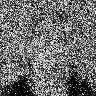

0.55 %


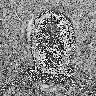

0.04 %


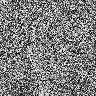

38.4 %


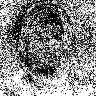

1.27 %


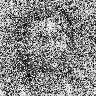

2.9 %


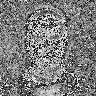

1.39 %


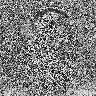

66.43 %


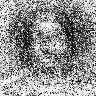

0.02 %


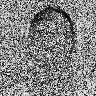

8.41 %


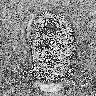

7.48 %


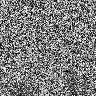

0.11 %


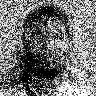

2.27 %


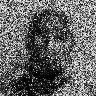

1.39 %


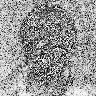

0.23 %


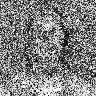

1.97 %


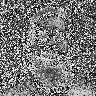

0.07 %


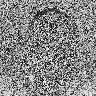

0.76 %


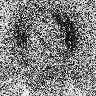

0.37 %


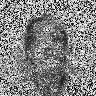

33.35 %


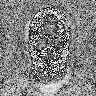

0.69 %


In [32]:
samples_to_try = torch.randn(samples_amount, generator_entry).to(device=device)
generated_samples = generator(samples_to_try)
discriminated_samples = discriminator(generated_samples)

generated_samples = generated_samples.cpu().detach()
discriminated_samples = discriminated_samples.cpu().detach()

avg = sum(float(x) for x in discriminated_samples)/150
print("Average score :", round(avg * 100, 2), "%")

for i in range(samples_amount):
    image = transforms.ToPILImage()(generated_samples[i].reshape(image_size, image_size))
    display.display(image)
    print(round(float(discriminated_samples[i]) * 100, 2), "%")